In [1]:
from hierarchy import *
from glm import *
from benlib.plot import scatter_cc, remove_frames, label_bottom_right
set_publication_figure_defaults()
fig_num = 7

clusters = Clusters(19)
clusters.summarize()

post_spike_bfs = get_spike_history_bfs()
coupling_bfs = get_coupling_bfs()

NR <= 200:
Anaesthetised: ic: 411, mgb: 190, mgbm:  81, ac: 146, total:  828
Awake:         ic: 148, mgb:   0, mgbm:   0, ac:  63, total:  211
Total:         ic: 559, mgb: 190, mgbm:  81, ac: 209, total: 1039

NR > 200:
Anaesthetised: ic:  16, mgb:  27, mgbm:  25, ac:   5, total:   73
Awake:         ic:   1, mgb:   0, mgbm:   0, ac:   2, total:    3
Total:         ic:  17, mgb:  27, mgbm:  25, ac:   7, total:   76



In [2]:
cortex_active_text = 'Cortex active'
cortex_silenced_text = 'Cortex silenced'

In [3]:
# load GLM fits -- expect 542 (of I think 558)

clusters.load_analyses(['glm_fits_main'])
clusters.clusters = [c for c in clusters.clusters if 'glm_fits_main' in c]
print(len(clusters.clusters))

Loading "main GLM fits"
Fieldname: glm_fits_main
/Users/ben/projects/michael-data/hierarchy/results/stim-19/fit_glms_sparse_cvglmnet_all_conditions--n_reps_train=5--n_reps_test=2
Found data files with 542 clusters
** Missing more than 15 results **

542


In [4]:
fit_type = 'best_fit'
# fit_type = 'compromise_lambda'

if fit_type == 'compromise_lambda':
    print('Using compromise lambda values')
else:
    print('Using best-fit lambda')

for c in clusters.clusters:
    if 'glms' not in c:
        c['glm_cc_test_gt_thresh'] = False
        continue

    for key_idx, key in enumerate(['light_off', 'light_on']):
        
        for kernel_type in ['stimulus', 'stimulus+spike_history', 
                        'stimulus+coupling', 'stimulus+spike_history+coupling']:

            data = c['glms'][key][kernel_type]
            data['cc_test']

            if fit_type=='compromise_lambda':
                coeffs = data['compromise_lambda']['coeffs']
                coeffs = coeffs[1:] # drop constant term
            else:
                best_fit = np.where(data['cvfit']['lambdau']==\
                                    data['cvfit']['lambda_min'])[0][0]
                coeffs = data['cvfit']['glmnet_fit']['beta'][:,best_fit].squeeze()

            kernels = unpack_kernel(coeffs, kernel_type,
                                    post_spike_bfs=post_spike_bfs,
                                    coupling_bfs=coupling_bfs)

            c['glms'][key][kernel_type]['kernels'] = kernels
            c['glm_cc_test_gt_thresh'] = c['glms']['light_on']['stimulus']['cc_test']>.05 and \
                                         (c['glms']['light_on']['stimulus+coupling']['cc_test'] - \
                                          c['glms']['light_on']['stimulus']['cc_test'])>.0
            #c['noiseratio']<20 #data['cc_test']>.3

Using best-fit lambda


In [5]:
# select IC unit

# sort IC clusters in descending order of how much coupling helps in light off condition
ic_clusters = clusters.select_data(brain_area='ic')
# ic_clusters = [c for c in ic_clusters if 'glms' in c]
fit_quality = np.array([(c['glm_fits_main']['light_off']['stimulus+coupling']['cc_test'] -\
               c['glm_fits_main']['light_on']['stimulus+coupling']['cc_test']) \
               for c in ic_clusters])
ic_sort_order = np.argsort(-fit_quality)
ic_clusters_sorted = [ic_clusters[idx] for idx in ic_sort_order]

for idx, c in enumerate(ic_clusters_sorted):
    fit_quality = c['glm_fits_main']['light_off']['stimulus+coupling']['cc_test'] -\
                  c['glm_fits_main']['light_on']['stimulus+coupling']['cc_test']
    
    data = c['glm_fits_main']['light_off']['stimulus+coupling']
    best_fit = np.where(data['cvfit']['lambdau']==\
                        data['cvfit']['lambda_min'])[0][0]
    coeffs = data['cvfit']['glmnet_fit']['beta'][:,best_fit].squeeze()
    kernels_light_off = unpack_kernel(coeffs, 'stimulus+coupling',
                                      post_spike_bfs=post_spike_bfs,
                                      coupling_bfs=coupling_bfs)

    data = c['glm_fits_main']['light_on']['stimulus+coupling']
    best_fit = np.where(data['cvfit']['lambdau']==\
                        data['cvfit']['lambda_min'])[0][0]
    coeffs = data['cvfit']['glmnet_fit']['beta'][:,best_fit].squeeze()
    kernels_light_on = unpack_kernel(coeffs, 'stimulus+coupling',
                                      post_spike_bfs=post_spike_bfs,
                                      coupling_bfs=coupling_bfs)
    
    coupling_similarity = np.corrcoef(kernels_light_off['coupling'].ravel(),
                                      kernels_light_on['coupling'].ravel())[0,1]
    if coupling_similarity > .85:
        print(idx, coupling_similarity)
        break

26 0.9255382806236633


Using best-fit lambda values
Using best-fit lambda values


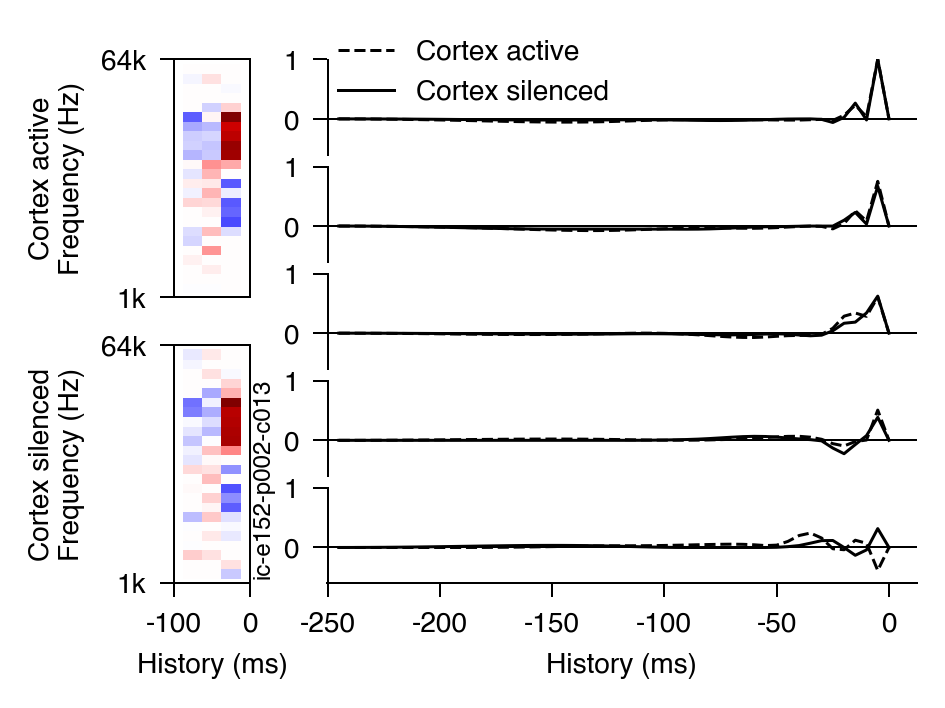

In [6]:
# choose a unit to look at
from matplotlib import rcParams
from benlib.strf import show_strf

plt.figure(figsize=(9/2.54,6/2.54))
show_legend = True # need to paste in legend if False

# c = ic_clusters[ic_sort_order[17]]
c = ic_clusters_sorted[26]

ls = ['--', '-']

kernel_type = 'stimulus+coupling'

fig = plt.gcf()
gs = fig.add_gridspec(1,12)
ax = fig.add_subplot(gs[3:])

for key_idx, key in enumerate(['light_off', 'light_on']):
    data = c['glm_fits_main'][key][kernel_type]
    
    if fit_type=='compromise_lambda':
        print('Using compromise lambda values')
        coeffs = data['compromise_lambda']['coeffs']
        coeffs = coeffs[1:] # drop constant term
    else:
        print('Using best-fit lambda values')
        best_fit = np.where(data['cvfit']['lambdau']==\
                            data['cvfit']['lambda_min'])[0][0]
        coeffs = data['cvfit']['glmnet_fit']['beta'][:,best_fit].squeeze()

    kernels = unpack_kernel(coeffs, kernel_type,
                            post_spike_bfs=post_spike_bfs,
                            coupling_bfs=coupling_bfs)

    plt.subplot(2,4,1+4*key_idx)
#     plt.imshow(kernels['stimulus'].T,
#                interpolation='none',
#                aspect=.5,
#                origin='lower')
    axs = plt.gca()
    show_strf(kernels['stimulus'].T, ax=axs)
    axs.set_aspect(.5)
    plt.xticks((-.5,3.5),['-100', '0'])
    lab = cortex_active_text if key=='light_off' else cortex_silenced_text
    if key_idx==0:
        plt.xticks([])
    if key_idx==1:
        plt.xlabel('History (ms)')
        xl = plt.xlim()
        yl = plt.ylim()
        plt.text(xl[0]+(xl[1]-xl[0])*1.03, yl[0],
                 c['unique_id'], size=6, rotation=90, va='bottom')
    plt.yticks((-.5,24.5),['1k', '64k'])
    plt.ylabel(lab+'\nFrequency (Hz)')

#     if 'spike_history' in kernels:
#         plt.subplot(3,2,5)
#         plt.plot(kernels['spike_history'], color='tab:blue', linestyle=ls[key_idx])
#         plt.legend(['Light off', 'Light on'])
#         leg1 = plt.gca().get_legend()

    scale = 1.8
    neg_extent = .6
    if 'coupling' in kernels:
        plt.sca(ax)

        n_to_show = 5
        coupling = kernels['coupling']
        n_clusters = len(coupling)
#         plt.subplot(1,2,2)
        mx = [np.max(np.abs(c)) for c in coupling]
        idx = np.argsort([m for m in mx])
        mx = np.max(mx)
        coupling = [coupling[i]/mx for i in idx][-n_to_show:]
        coupling = [c+scale*i for i,c in enumerate(coupling)]
        coupling = np.fliplr(np.vstack(coupling))
        [plt.axhline(i*scale, color='k', lw=rcParams['ytick.major.width'], label='_nolegend_')
            for i in range(n_to_show)]
        ytickpos = []
        yticklabels = []
        for i in range(n_to_show):
            ytickpos.extend([i*scale, i*scale+1])
            yticklabels.extend([0,1])
        [plt.plot([0, 0],[i*scale-neg_extent, i*scale+1],
                  color='k', lw=rcParams['ytick.major.width'], label='_nolegend_')
            for i in range(n_to_show)]
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.plot(np.arange(1,51), coupling.T, color='k', linestyle=ls[key_idx])
        
        if show_legend:
            plt.legend([cortex_active_text, cortex_silenced_text], loc=(0,.89), frameon=False)
            leg2 = plt.gca().get_legend()
        plt.ylim(-neg_extent,(n_to_show-1)*scale+1)
        plt.yticks(ytickpos, yticklabels)
        xl = plt.xlim()
        plt.xlim([-.075, xl[1]])
        plt.xticks(np.arange(0,51,10), np.arange(-5*50,1,5*10))
        plt.xlabel('History (ms)')

if show_legend:
    # leg1.legendHandles[1].set_linestyle('-')
    leg2.legendHandles[1].set_linestyle('-')

plt.savefig('figure-%d-coupling-kernel-example-ic.pdf' % fig_num)

In [7]:
# select MGB unit 

# sort MGB clusters in descending order of how much coupling helps in light off condition
mgb_clusters = clusters.select_data(brain_area='mgb')
# mgb_clusters = [c for c in mgb_clusters if 'glms' in c]
fit_quality = np.array([(c['glm_fits_main']['light_off']['stimulus+coupling']['cc_test']) #-\
#                c['glm_fits_main']['light_on']['stimulus+coupling']['cc_test']) \
               for c in mgb_clusters])
mgb_sort_order = np.argsort(-fit_quality)
mgb_clusters_sorted = [mgb_clusters[idx] for idx in mgb_sort_order]

for idx, c in enumerate(mgb_clusters_sorted):
    fit_quality = c['glm_fits_main']['light_off']['stimulus+coupling']['cc_test'] #-\
#                   c['glm_fits_main']['light_on']['stimulus+coupling']['cc_test']
    
    data = c['glm_fits_main']['light_off']['stimulus+coupling']
    best_fit = np.where(data['cvfit']['lambdau']==\
                        data['cvfit']['lambda_min'])[0][0]
    coeffs = data['cvfit']['glmnet_fit']['beta'][:,best_fit].squeeze()
    kernels_light_off = unpack_kernel(coeffs, 'stimulus+coupling',
                                      post_spike_bfs=post_spike_bfs,
                                      coupling_bfs=coupling_bfs)

    data = c['glm_fits_main']['light_on']['stimulus+coupling']
    best_fit = np.where(data['cvfit']['lambdau']==\
                        data['cvfit']['lambda_min'])[0][0]
    coeffs = data['cvfit']['glmnet_fit']['beta'][:,best_fit].squeeze()
    kernels_light_on = unpack_kernel(coeffs, 'stimulus+coupling',
                                      post_spike_bfs=post_spike_bfs,
                                      coupling_bfs=coupling_bfs)
    
    coupling_similarity = np.corrcoef(kernels_light_off['coupling'].ravel(),
                                      kernels_light_on['coupling'].ravel())[0,1]
    if coupling_similarity < .45:
        print(idx, fit_quality, coupling_similarity)
        break

7 0.44831160730184144 0.42455698868609193


Using best-fit lambda values
Using best-fit lambda values


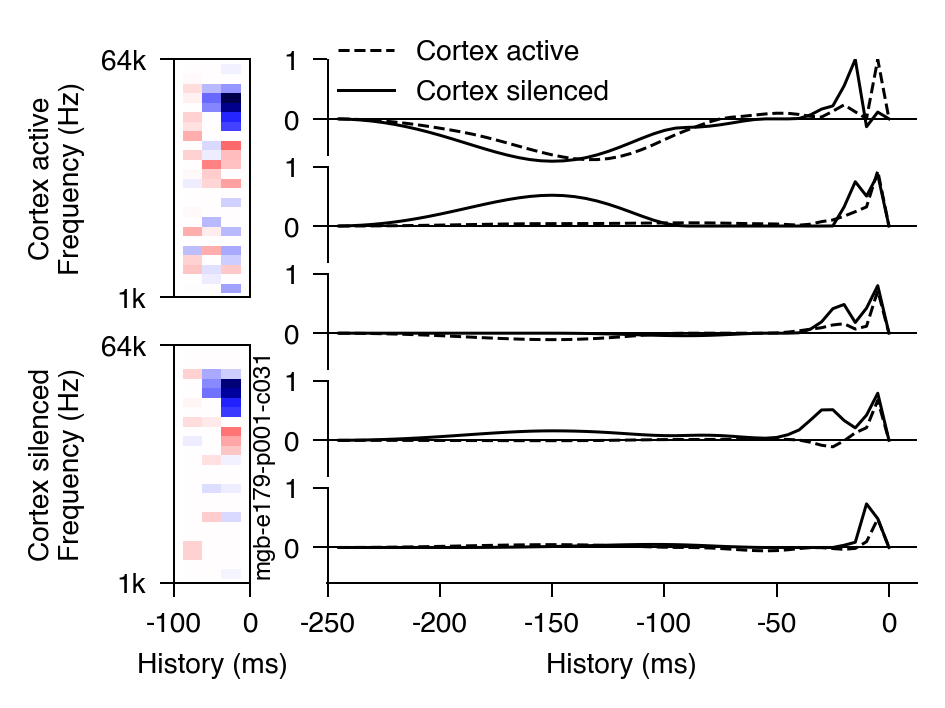

In [8]:
# choose a unit to look at
from matplotlib import rcParams

plt.figure(figsize=(9/2.54,6/2.54))
show_legend = True # need to paste in legend if False

# c = mgb_clusters[mgb_sort_order[3]]
c = mgb_clusters_sorted[35]

ls = ['--', '-']

kernel_type = 'stimulus+coupling'

fig = plt.gcf()
gs = fig.add_gridspec(1,12)
ax = fig.add_subplot(gs[3:])

for key_idx, key in enumerate(['light_off', 'light_on']):
    data = c['glm_fits_main'][key][kernel_type]
    
    if fit_type=='compromise_lambda':
        print('Using compromise lambda values')
        coeffs = data['compromise_lambda']['coeffs']
        coeffs = coeffs[1:] # drop constant term
    else:
        print('Using best-fit lambda values')
        best_fit = np.where(data['cvfit']['lambdau']==\
                            data['cvfit']['lambda_min'])[0][0]
        coeffs = data['cvfit']['glmnet_fit']['beta'][:,best_fit].squeeze()

    kernels = unpack_kernel(coeffs, kernel_type,
                            post_spike_bfs=post_spike_bfs,
                            coupling_bfs=coupling_bfs)

    plt.subplot(2,4,1+4*key_idx)
#     plt.imshow(kernels['stimulus'].T,
#                interpolation='none',
#                aspect=.5,
#                origin='lower')
    axs = plt.gca()
    show_strf(kernels['stimulus'].T, ax=axs)
    axs.set_aspect(.5)
    plt.xticks((-.5,3.5),['-100', '0'])
    lab = cortex_active_text if key=='light_off' else cortex_silenced_text
    if key_idx==0:
        plt.xticks([])
    if key_idx==1:
        plt.xlabel('History (ms)')
        xl = plt.xlim()
        yl = plt.ylim()
        plt.text(xl[0]+(xl[1]-xl[0])*1.03, yl[0],
                 c['unique_id'], size=6, rotation=90, va='bottom')
    plt.yticks((-.5,24.5),['1k', '64k'])
    plt.ylabel(lab+'\nFrequency (Hz)')

#     if 'spike_history' in kernels:
#         plt.subplot(3,2,5)
#         plt.plot(kernels['spike_history'], color='tab:blue', linestyle=ls[key_idx])
#         plt.legend(['Light off', 'Light on'])
#         leg1 = plt.gca().get_legend()

    scale = 1.8
    neg_extent = .6
    if 'coupling' in kernels:
        plt.sca(ax)

        n_to_show = 5
        coupling = kernels['coupling']
        n_clusters = len(coupling)
#         plt.subplot(1,2,2)
        mx = [np.max(np.abs(c)) for c in coupling]
        idx = np.argsort([m for m in mx])
        mx = np.max(mx)
        coupling = [coupling[i]/mx for i in idx][-n_to_show:]
        coupling = [c+scale*i for i,c in enumerate(coupling)]
        coupling = np.fliplr(np.vstack(coupling))
        [plt.axhline(i*scale, color='k', lw=rcParams['ytick.major.width'], label='_nolegend_')
            for i in range(n_to_show)]
        ytickpos = []
        yticklabels = []
        for i in range(n_to_show):
            ytickpos.extend([i*scale, i*scale+1])
            yticklabels.extend([0,1])
        [plt.plot([0, 0],[i*scale-neg_extent, i*scale+1],
                  color='k', lw=rcParams['ytick.major.width'], label='_nolegend_')
            for i in range(n_to_show)]
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.plot(np.arange(1,51), coupling.T, color='k', linestyle=ls[key_idx])
        
        if show_legend:
            plt.legend([cortex_active_text, cortex_silenced_text], loc=(0,.89), frameon=False)
            leg2 = plt.gca().get_legend()
        plt.ylim(-neg_extent,(n_to_show-1)*scale+1)
        plt.yticks(ytickpos, yticklabels)
        xl = plt.xlim()
        plt.xlim([-.075, xl[1]])
        plt.xticks(np.arange(0,51,10), np.arange(-5*50,1,5*10))
        plt.xlabel('History (ms)')

if show_legend:
    # leg1.legendHandles[1].set_linestyle('-')
    leg2.legendHandles[1].set_linestyle('-')

plt.savefig('figure-%d-coupling-kernel-example-mgb.pdf' % fig_num)